In [1]:
## Uncomment these lines if running as a google colab notebook: 
##! git clone https://github.com/kundajelab/adar_editing
##import os
##os.chdir("adar_editing/xgboost_with_shap/")
##!pip install -e https://github.com/slundberg/shap
##!pip install --upgrade xgboost
##!pip install cufflinks

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
%load_ext autoreload
%autoreload 2   

In [2]:
#helper utilities for model training and interpretation 
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

#init_notebook_mode(connected=False)


/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



## TTYH2 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
 </ol>


## TTYH2 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [3]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv",header=0,sep=',',index_col=0)

In [4]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [5]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(363, 168)
{24.0: 32, 25.0: 33, 26.0: 41, 27.0: 42, 28.0: 31, 29.0: 23, 30.0: 24, 31.0: 34, 32.0: 25, 33.0: 21, 48.0: 37, 67.0: 20}


In [6]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [7]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [8]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u2_3prm_cp_internal
d3_5prm_cp_hairpin
mut_ref_struct:S
u3_length_internal_es
site_3prm_cp_internal:A:U
site_3prm_cp_internal:U:G
u_hairpin_length
site_length_hairpin
d3_5prm_cp_internal
d3_length_internal_es
d2_5prm_cp_internal:G:C
d3_length_bulge
mut_type:wt
u3_3prm_cp_bulge:G:C
u3_5prm_cp_bulge:G:C
d3_length_internal_ecs
mut_ref_nt:U
mut_ref_struct:I
u1_exist
site_3prm_cp_internal:G:U
mut_struct:B
u2_length_internal_es
u2_length_internal_ecs
site_prev_nt:C
d2_length_hairpin
u3_5prm_cp_internal
d3_length_hairpin
d3_3prm_cp_bulge
mut_nt:C
u3_3prm_cp_internal
mut_ref_nt:G
site_next_nt:G
mut_exist
u1_length_internal_es
d2_5prm_cp_hairpin
u1_3prm_cp_internal
u1_length_internal_ecs
d1_exist
u1_length_hairpin
mut_type:mismatch
d1_5prm_cp_hairpin
u3_struct:B
u1_5prm_cp_hairpin
u3_length_bulge
d2_exist
mut_ref_nt:C
u2_5prm_cp_internal
u3_length_internal_ecs
u1_5prm_cp_internal
site_5prm_cp_hairpin
u3_exist
d3_3prm_cp_internal
d3_5prm_cp_bulge
mut_prev_struct:H
u2_exist
d1_length_hairpin


In [9]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [10]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [11]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(226, 111)
(226,)
(69, 111)
(69,)
(67, 111)
(67,)


In [12]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [13]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [14]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [15]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-auc:0.899315	eval-mae:0.322032	eval-map:1	eval-aucpr:0.64448	eval-rmse:0.329703	train-auc:0.887282	train-mae:0.305079	train-map:1	train-aucpr:0.542315	train-rmse:0.3189
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-auc:0.899002	eval-mae:0.227523	eval-map:1	eval-aucpr:0.645126	eval-rmse:0.233441	train-auc:0.887201	train-mae:0.215109	train-map:1	train-aucpr:0.544858	train-rmse:0.225329
[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.898546	eval-mae:0.161577	eval-map:1	eval-aucpr:0.642388	eval-rmse:0.166262	train-auc:0.887203	train-mae:0.151855

[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.92696	eval-mae:0.003586	eval-map:1	eval-aucpr:0.656848	eval-rmse:0.016828	train-auc:0.917752	train-mae:0.000615	train-map:1	train-aucpr:0.560158	train-rmse:0.000913
[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.927052	eval-mae:0.003527	eval-map:1	eval-aucpr:0.656918	eval-rmse:0.016844	train-auc:0.917801	train-mae:0.000554	train-map:1	train-aucpr:0.560174	train-rmse:0.000815
[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.927115	eval-mae:0.003504	eval-map:1	eval-aucpr:0.656928	eval-rmse:0.016876	train-auc:0.91781	train-mae:0.000495	train-map:1	train-aucpr:0.560178	train-rmse:0.000718
[15:20:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra

In [16]:
# save to binary file for faster loading
bst.save_model('ttyh2.bc.degenerate.model')
# save model to text file 
bst.dump_model('ttyh2.bc.degenerate.raw.txt')


In [17]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

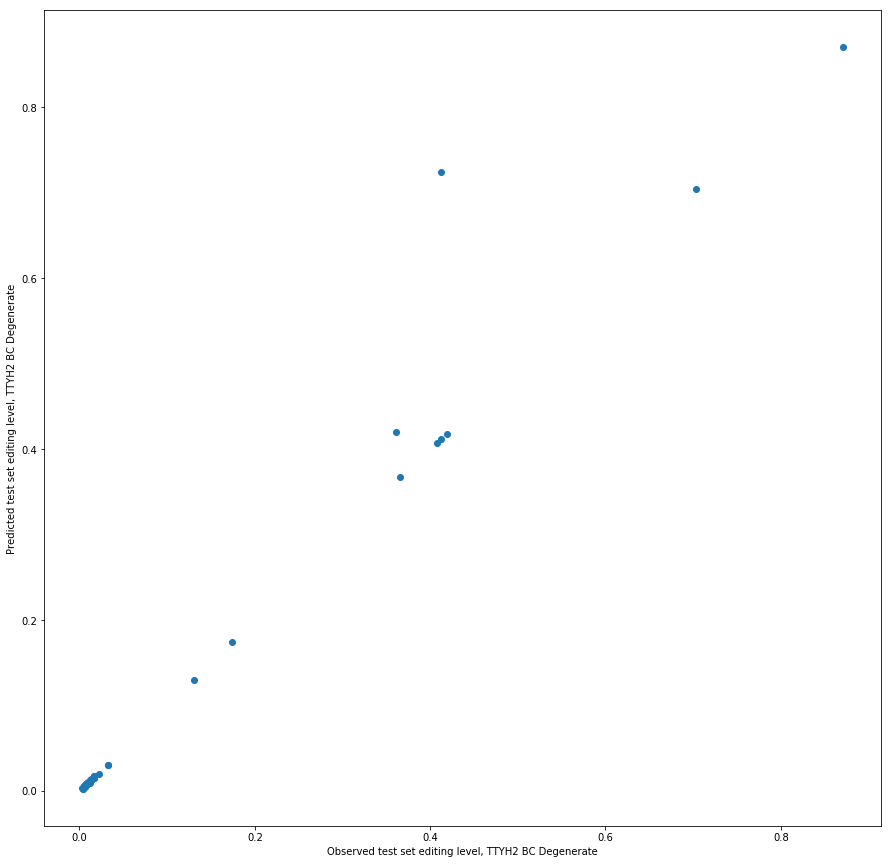

In [18]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, TTYH2 BC Degenerate")
plt.ylabel("Predicted test set editing level, TTYH2 BC Degenerate")
plt.show()

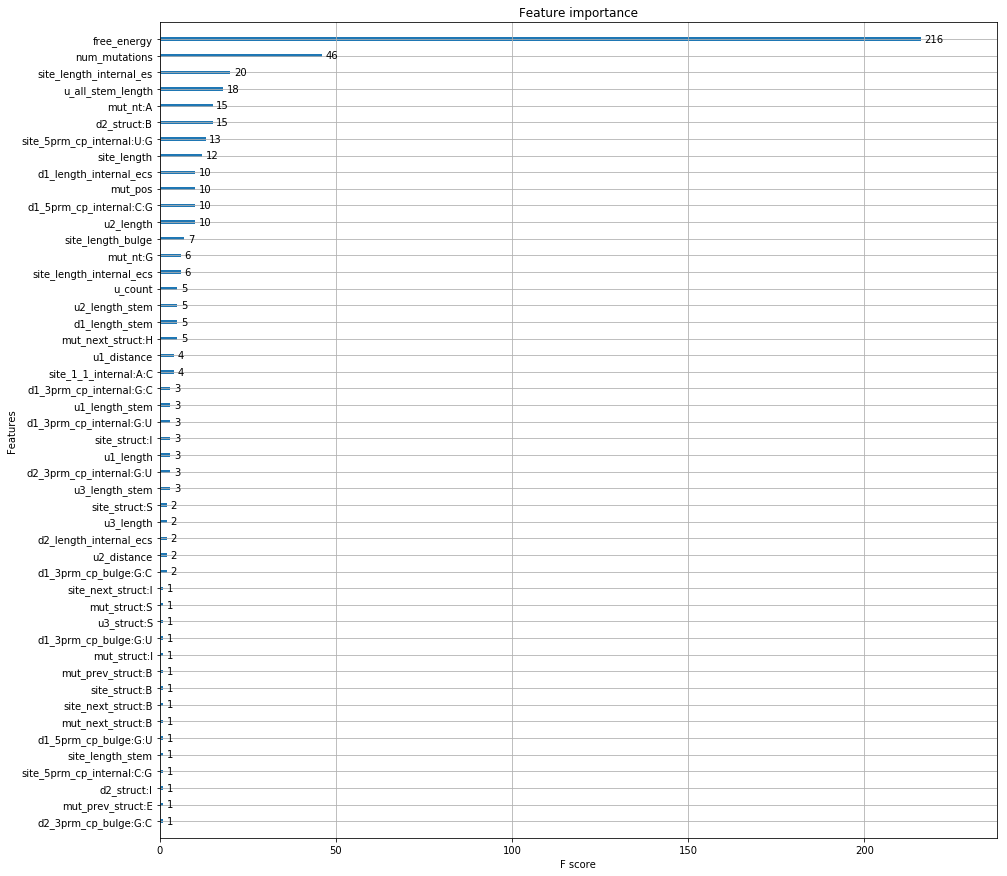

In [19]:
xgboost.plot_importance(bst)

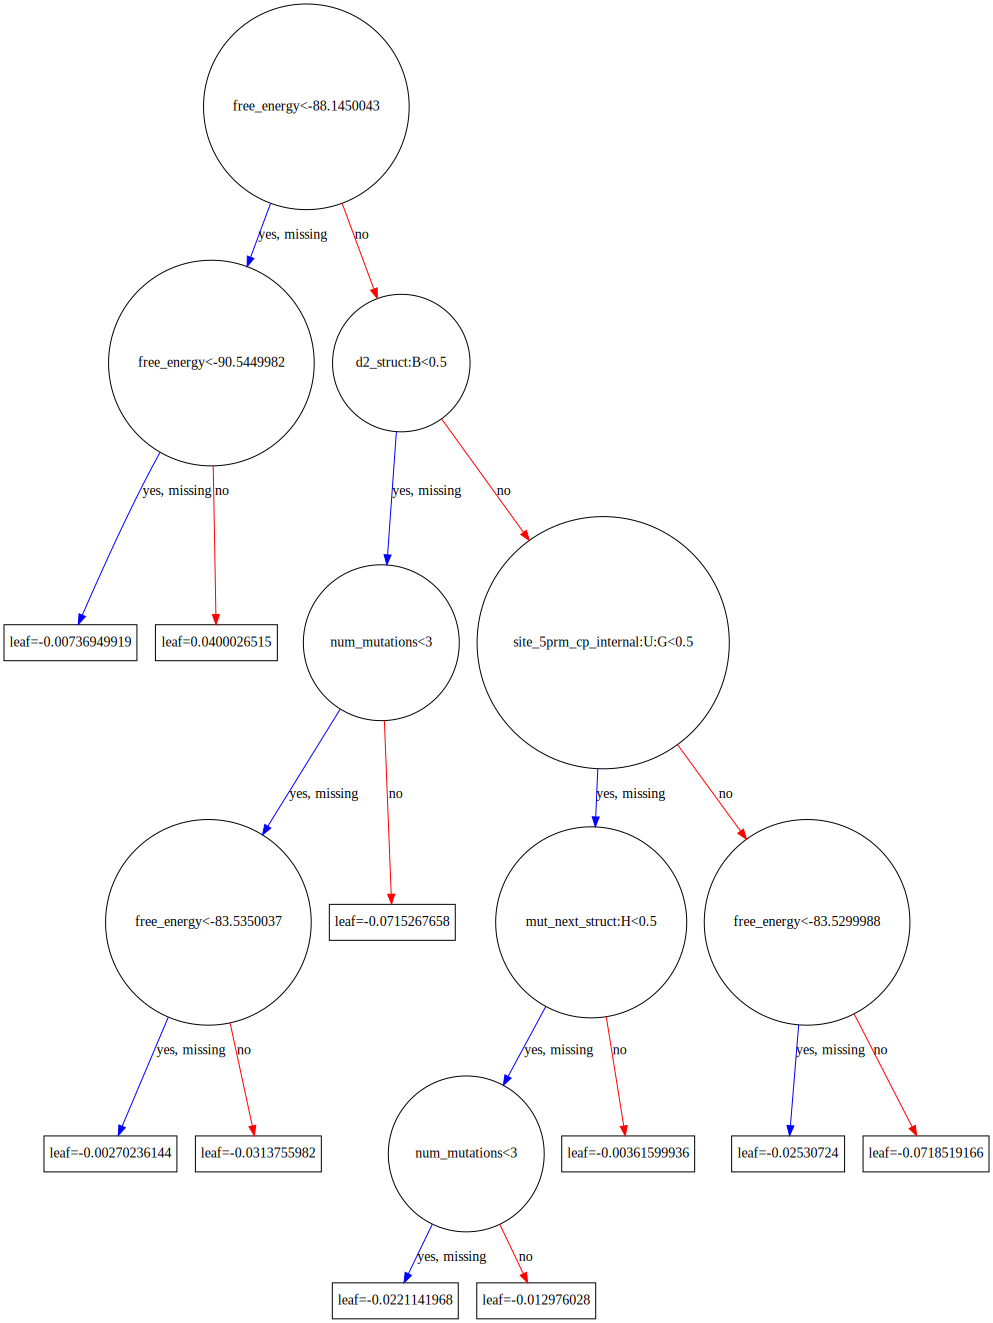

In [20]:
xgboost.to_graphviz(bst, num_trees=2)


In [21]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [22]:
shap_values.shape

(67, 111)

In [23]:
# visualize prediction for isoform with the highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [24]:
# visualize prediction for isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [25]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

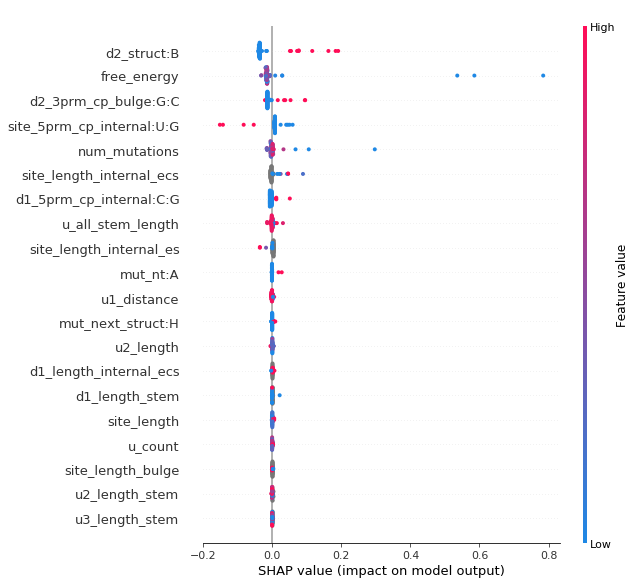

In [26]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


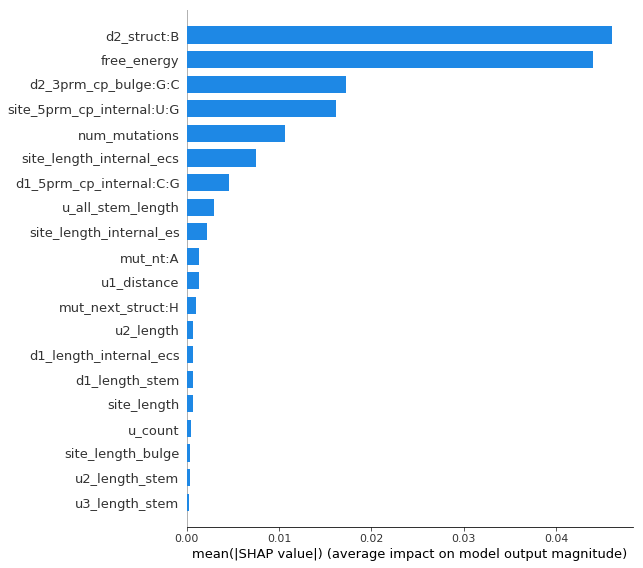

In [27]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [28]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [29]:
shap_interaction_values.shape

(67, 111, 111)

In [30]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [31]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [32]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [33]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [34]:
import feature_subsets 

In [35]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.09053146

In [36]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.003431686

In [37]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.035011057

In [38]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.39856544

In [39]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.43357652

In [40]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.093963146

In [41]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.4925286

In [42]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.12897421

In [43]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.06743274

In [44]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [45]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.08347907

In [46]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.067186736

In [47]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['free_energy*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*',

0.7101512

## TTYH2 Computational features <a name='3'>
<a href=#outline>Home</a>

In [48]:
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)

In [49]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [50]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 212)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [51]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [52]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [53]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u3_length_internal_es
u3_3prm_cp_bulge:C:G
u2_3prm_cp_bulge:U:G
d3_3prm_cp_internal:C:G
u1_struct:B
d2_3prm_cp_bulge:U:A
u1_3prm_cp_bulge:C:G
d2_length_hairpin
d1_5prm_cp_internal:G:C
u1_3prm_cp_bulge:A:U
u1_struct:H
u1_5prm_cp_hairpin:A:U
u3_length_internal_ecs
u1_struct:S
u2_struct:E
site_5prm_cp_hairpin
site_next_nt:U
u2_exist
d1_length_hairpin
site_next_nt:A
d3_5prm_cp_internal:A:U
site_length_hairpin
d3_length_internal_es
d1_5prm_cp_internal:A:U
d3_length_bulge
site_prev_struct:H
u1_length_bulge
site_5prm_cp_bulge:U:G
site_3prm_cp_bulge:G:U
mut_ref_struct:I
d2_5prm_cp_internal:U:G
d3_length_hairpin
site_5prm_cp_internal:G:C
mut_ref_struct:B
u1_length_internal_es
d2_5prm_cp_hairpin
mut_next_struct:E
d1_exist
d2_3prm_cp_internal:U:A
d1_3prm_cp_internal:A:U
d1_5prm_cp_bulge:A:U
u3_5prm_cp_bulge:A:U
d1_3prm_cp_bulge:C:G
d2_3prm_cp_internal:C:G
site_5prm_cp_internal:U:G
u1_5prm_cp_bulge:U:G
u2_3prm_cp_internal
d3_5prm_cp_hairpin
u2_3prm_cp_bulge:G:C
d3_struct:B
d3_struct:I
u1_exist
u3_

In [54]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [55]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [56]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(419, 123)
(419,)
(86, 123)
(86,)
(108, 123)
(108,)


In [57]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [58]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [59]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [60]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.73047	eval-mae:0.264438	eval-map:1	eval-aucpr:0.254649	eval-rmse:0.284	train-auc:0.70351	train-mae:0.248325	train-map:1	train-aucpr:0.308441	train-rmse:0.267713
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.724597	eval-mae:0.199998	eval-map:1	eval-aucpr:0.257068	eval-rmse:0.219969	train-auc:0.742196	train-mae:0.177211	train-map:1	train-aucpr:0.327122	train-rmse:0.193552
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.748134	eval-mae:0.148965	eval-map:1	eval-aucpr:0.267561	eval-rmse:0.165751	train-auc:0.75818	train-mae:0.126878	tr

[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.770808	eval-mae:0.039844	eval-map:1	eval-aucpr:0.296275	eval-rmse:0.057111	train-auc:0.778679	train-mae:0.011149	train-map:1	train-aucpr:0.349797	train-rmse:0.015658
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.770763	eval-mae:0.040131	eval-map:1	eval-aucpr:0.296215	eval-rmse:0.057486	train-auc:0.778867	train-mae:0.010648	train-map:1	train-aucpr:0.350001	train-rmse:0.014992
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.771272	eval-mae:0.039911	eval-map:1	eval-aucpr:0.296534	eval-rmse:0.057162	train-auc:0.778931	train-mae:0.01038	train-map:1	train-aucpr:0.350028	train-rmse:0.014711
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extr

[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-auc:0.771375	eval-mae:0.03888	eval-map:1	eval-aucpr:0.296909	eval-rmse:0.056203	train-auc:0.780283	train-mae:0.004957	train-map:1	train-aucpr:0.351431	train-rmse:0.007199
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-auc:0.77132	eval-mae:0.038804	eval-map:1	eval-aucpr:0.296861	eval-rmse:0.056172	train-auc:0.780298	train-mae:0.004883	train-map:1	train-aucpr:0.351446	train-rmse:0.007059
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-auc:0.771159	eval-mae:0.038718	eval-map:1	eval-aucpr:0.296571	eval-rmse:0.056074	train-auc:0.78034	train-mae:0.004571	train-map:1	train-aucpr:0.351501	train-rmse:0.006628
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra 

[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[81]	eval-auc:0.773483	eval-mae:0.037555	eval-map:1	eval-aucpr:0.296186	eval-rmse:0.055048	train-auc:0.780622	train-mae:0.002024	train-map:1	train-aucpr:0.351767	train-rmse:0.002838
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[82]	eval-auc:0.77347	eval-mae:0.037511	eval-map:1	eval-aucpr:0.296431	eval-rmse:0.055013	train-auc:0.780625	train-mae:0.001954	train-map:1	train-aucpr:0.351771	train-rmse:0.002738
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[83]	eval-auc:0.773481	eval-mae:0.037495	eval-map:1	eval-aucpr:0.296433	eval-rmse:0.054994	train-auc:0.780628	train-mae:0.001908	train-map:1	train-aucpr:0.351774	train-rmse:0.002682
[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extr

[15:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[108]	eval-auc:0.773224	eval-mae:0.037458	eval-map:1	eval-aucpr:0.296043	eval-rmse:0.054889	train-auc:0.780664	train-mae:0.001279	train-map:1	train-aucpr:0.351814	train-rmse:0.001806
[15:20:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[109]	eval-auc:0.773224	eval-mae:0.037458	eval-map:1	eval-aucpr:0.296043	eval-rmse:0.054889	train-auc:0.780664	train-mae:0.001279	train-map:1	train-aucpr:0.351814	train-rmse:0.001806
Stopping. Best iteration:
[99]	eval-auc:0.773224	eval-mae:0.037457	eval-map:1	eval-aucpr:0.296043	eval-rmse:0.054888	train-auc:0.780664	train-mae:0.001279	train-map:1	train-aucpr:0.351814	train-rmse:0.001806



In [61]:
# save to binary file for faster loading
bst.save_model('ttyh2.combined.computational.model')
# save model to text file 
bst.dump_model('ttyh2.combined.computational.raw.txt')


In [62]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

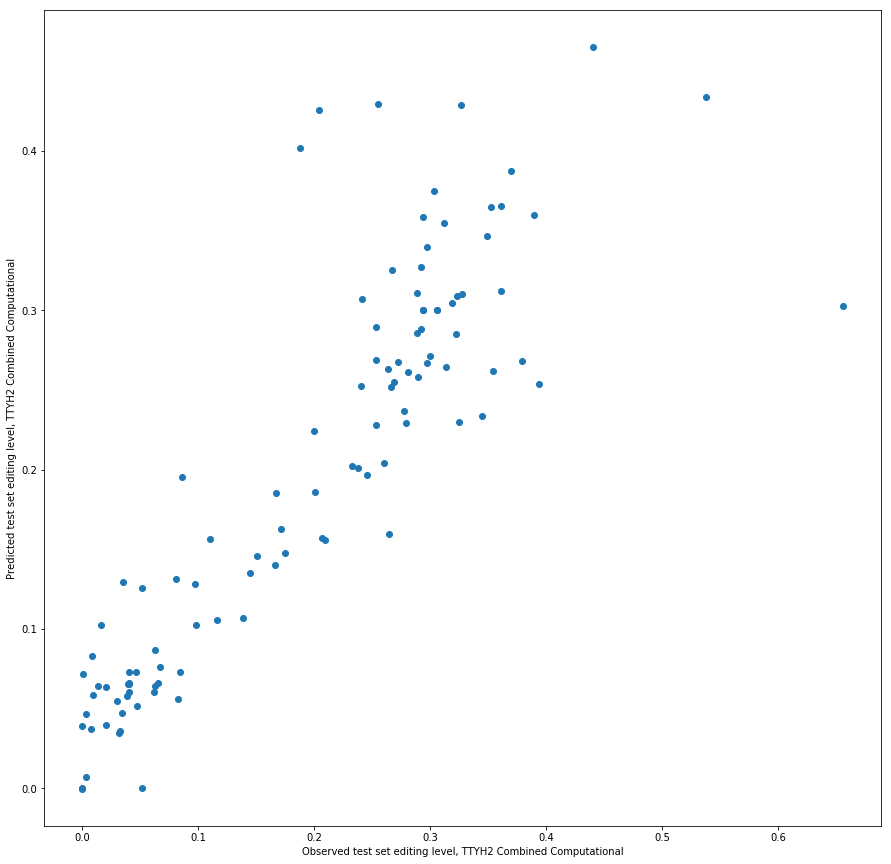

In [63]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, TTYH2 Combined Computational")
plt.ylabel("Predicted test set editing level, TTYH2 Combined Computational")
plt.show()

In [64]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [65]:
shap_values.shape

(108, 123)

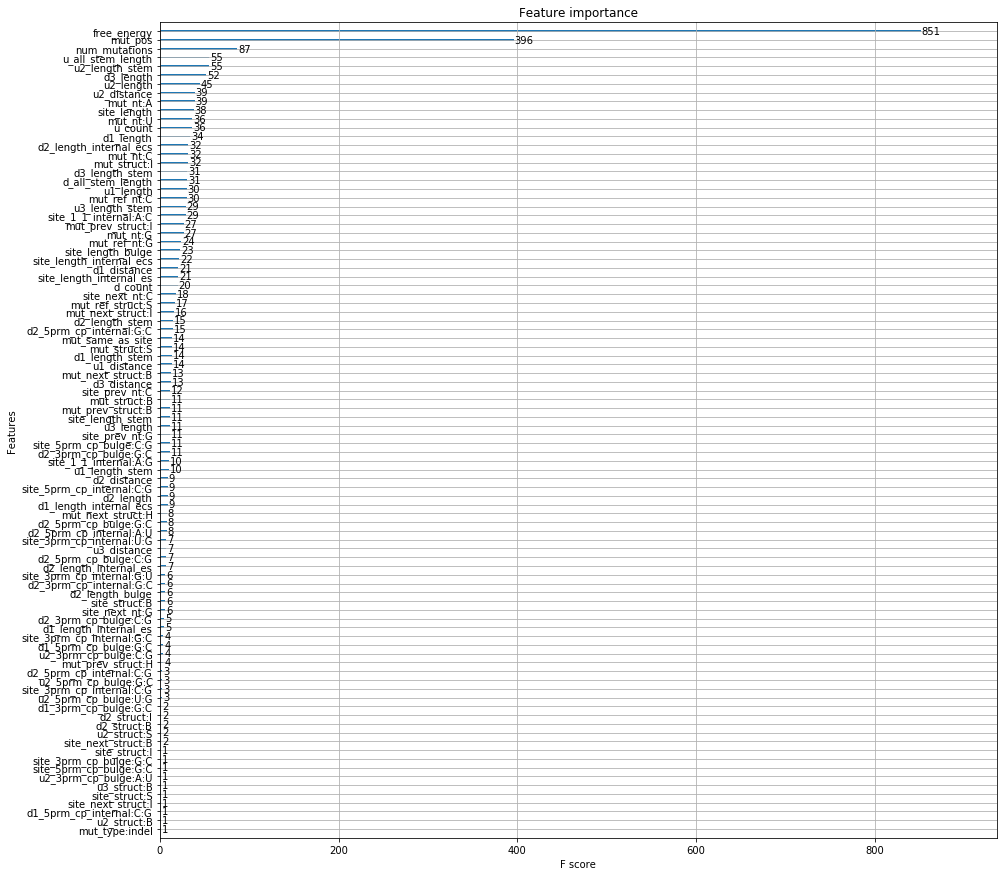

In [66]:
xgboost.plot_importance(bst)

In [67]:
# visualize prediction for isoform with highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [68]:
# visualize prediction for the isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [69]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

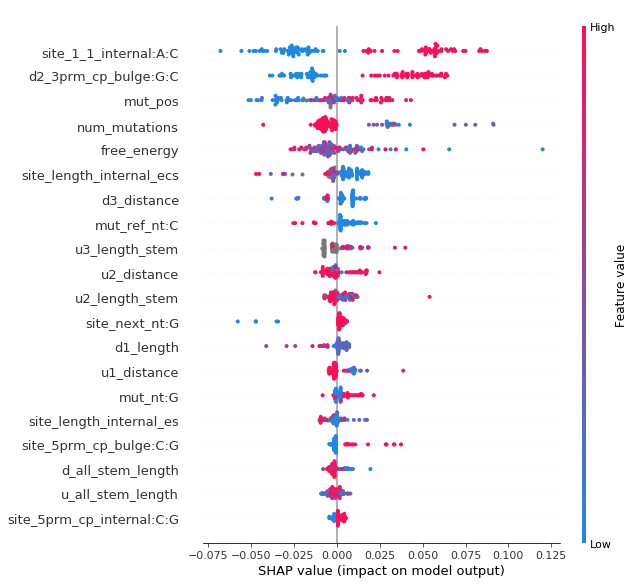

In [70]:
# summarize the effect of all the features 
shap.initjs()
shap.summary_plot(shap_values, test_X)


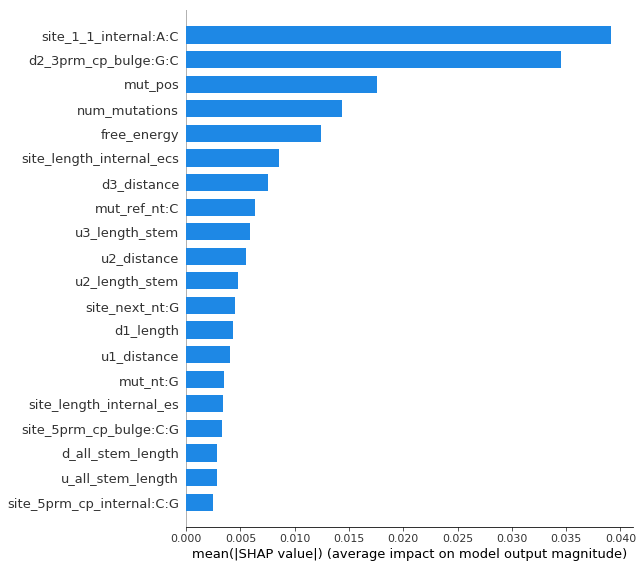

In [71]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [72]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [73]:
shap_interaction_values.shape

(108, 123, 123)

In [74]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [75]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [76]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [77]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [78]:
import feature_subsets 

In [79]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.21521853

In [80]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.022223841

In [81]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.12849504

In [82]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.2341472

In [83]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.36264226

In [84]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.23744239

In [85]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.47158962

In [86]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.3659374

In [87]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.06322044

In [88]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.04049074

In [89]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.19718464

In [90]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.17476128

In [91]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['free_energy*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*',

0.43714276